In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import imdb
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# classification data , inspired from "https://www.tensorflow.org/tutorials/keras/basic_text_classification"

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=10000,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)



dim = 256
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 256

/Users/beyrem/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


('x_train shape:', (25000, 256))
(25000, 'train samples')
(25000, 'test samples')


In [2]:
print(x_train.shape)


(25000, 256)


In [3]:
print(x_test.shape)


(25000, 256)


In [ ]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc

def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )

    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, self.W ) + b, lambda : tf.matmul(x, self.W ) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.sigmoid(x)
        log_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

In [ ]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):
    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        #optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.0000005).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
            
        acts1.append(act1)
            
    return all_accuracies, acts1

max_iters = 2000
lambdas = [1e-3,1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)

print('#### appox dropout ####')
acc_approxdrop, act1_approxdrop = training(lambdas, 'drop', max_iters)
      

In [3]:

import numpy as np
import tensorflow as tf
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from keras.datasets import reuters

(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

# A dictionary mapping words to an integer index
word_index = reuters.get_word_index(path="reuters_word_index.json")

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)



dim = 256
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=2

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

nb_classes=46
#Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

dim= 256
batch_size = 128
nb_hidden1 = 256
nb_hidden2 = 10

/Users/beyrem/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


('x_train shape:', (8982, 256))
(8982, 'train samples')
(2246, 'test samples')


In [37]:
x_train.shape

(8982, 256)

In [3]:
x_train[1]

array([1.0000e+00, 3.2670e+03, 6.9900e+02, 3.4340e+03, 2.2950e+03,
       5.6000e+01, 1.6784e+04, 7.5110e+03, 9.0000e+00, 5.6000e+01,
       3.9060e+03, 1.0730e+03, 8.1000e+01, 5.0000e+00, 1.1980e+03,
       5.7000e+01, 3.6600e+02, 7.3700e+02, 1.3200e+02, 2.0000e+01,
       4.0930e+03, 7.0000e+00, 1.9261e+04, 4.9000e+01, 2.2950e+03,
       1.3415e+04, 1.0370e+03, 3.2670e+03, 6.9900e+02, 3.4340e+03,
       8.0000e+00, 7.0000e+00, 1.0000e+01, 2.4100e+02, 1.6000e+01,
       8.5500e+02, 1.2900e+02, 2.3100e+02, 7.8300e+02, 5.0000e+00,
       4.0000e+00, 5.8700e+02, 2.2950e+03, 1.3415e+04, 3.0625e+04,
       7.7500e+02, 7.0000e+00, 4.8000e+01, 3.4000e+01, 1.9100e+02,
       4.4000e+01, 3.5000e+01, 1.7950e+03, 5.0500e+02, 1.7000e+01,
       1.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [ ]:
dim= 256

from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc

def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )
    
    elif mode == 'struc':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.matmul(tf.transpose(x), x) / batch_size
        cov += 1e-4 * tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))


    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, self.W) + b, lambda : tf.matmul(x, self.W) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.softmax(x)
        log_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

class Linear_Model_approxdrop:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W =   tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda :  self.X)
        x_all = tf.cond(self.train, lambda : tf.matmul(x, self.W) + b, lambda : tf.matmul(x, self.W) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.softmax(x_all)
        log_loss = (1-dim*(1-l/(l+1)))* tf.nn.softmax_cross_entropy_with_logits_v2(logits=x_all, labels=self.Y)
        for j in range(dim):
            mask = np.arange(dim) != j
#             tf_mask = tf.bool(tf.ones([dim]))
            #print(mask.shape)
            x_drop = x * mask
            x_drop = tf.cond(self.train, lambda : tf.matmul(x_drop, self.W) + b, lambda : tf.matmul(x_drop, self.W) + b)
            self.probs = tf.nn.softmax(x_drop)
            log_loss+= (1-l/(l+1)) * tf.nn.softmax_cross_entropy_with_logits_v2(logits=x_drop, labels=self.Y)            
        self.mean_log_loss = tf.reduce_mean(log_loss)

In [70]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    acts1 = []

    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cov_norms1 = [] ; cov_norms2 = []

        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
    #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer(0.00001).minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss= sess.run([optimiser, model.mean_log_loss], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    #print(np.sum(err1))
                    #print(np.sum(err2))
                    acc = np.sum(np.argmax(pred, axis=1) == 
                                 np.argmax(y_test, axis=1)) / float(nb_test)
                    accs.append(acc)                    
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
        acts1.append(act1)

    return all_accuracies,acts1

def training_approxdrop(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    acts1 = []

    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cov_norms1 = [] ; cov_norms2 = []

        model = Linear_Model_approxdrop(dim, nb_classes, batch_size, lamb, mode)
    #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer(0.00001).minimize(model.mean_log_loss)
        #0.00001
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss= sess.run([optimiser, model.mean_log_loss], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    #print(np.sum(err1))
                    #print(np.sum(err2))
                    acc = np.sum(np.argmax(pred, axis=1) == 
                                 np.argmax(y_test, axis=1)) / float(nb_test)
                    accs.append(acc)                    
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
        acts1.append(act1)

    return all_accuracies,acts1


max_iters = 12000
lambdas = [1e-4,1e10,1e+100]


print('#### No dropout ####')
#acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
#acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
#acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
#acc_drop, act1_drop = training(lambdas, 'drop', max_iters)

print('#### approx dropout ####')
acc_approxdrop, act1_approxdrop = training_approxdrop(lambdas,None, max_iters)


print('#### struc dropout ####')
#acc_struc, act1_struc = training(lambdas,None, max_iters)


#### No dropout ####
#### additive gaussian noise  ####
#### multiplicative gaussian noise ####
#### dropout ####
#### approx dropout ####
#### struc dropout ####
('Lamb', 0.0001)
Iteration: 0, 470.415
Accuracy: 0.009
Iteration: 200, 282.403
Accuracy: 0.084
Iteration: 400, 251.762
Accuracy: 0.136
Iteration: 600, 217.386
Accuracy: 0.156
Iteration: 800, 233.552
Accuracy: 0.175
Iteration: 1000, 142.675
Accuracy: 0.182
Iteration: 1200, 160.086
Accuracy: 0.191
Iteration: 1400, 103.624
Accuracy: 0.190
Iteration: 1600, 125.073
Accuracy: 0.190
Iteration: 1800, 110.452
Accuracy: 0.192
Iteration: 2000, 90.051
Accuracy: 0.188
Iteration: 2200, 74.293
Accuracy: 0.193
Iteration: 2400, 60.831
Accuracy: 0.199
Iteration: 2600, 57.487
Accuracy: 0.200
Iteration: 2800, 55.708
Accuracy: 0.199
Iteration: 3000, 52.422
Accuracy: 0.191
Iteration: 3200, 50.764
Accuracy: 0.186
Iteration: 3400, 45.836
Accuracy: 0.202
Iteration: 3600, 37.192
Accuracy: 0.199
Iteration: 3800, 29.167
Accuracy: 0.204
Iteration: 4000, 

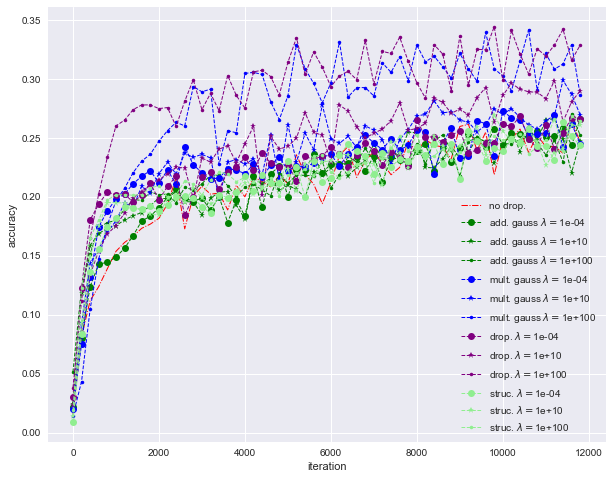

In [71]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

     
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

In [55]:
[np.max(accs) for accs in acc_linear]

[0.26447016918967053]

In [56]:
[np.max(accs) for accs in acc_add]

[0.26580587711487086, 0.26625111308993765, 0.27025823686553874]

In [57]:
[np.max(accs) for accs in acc_mult]

[0.27292965271593944, 0.298753339269813, 0.3414959928762244]

In [58]:
[np.max(accs) for accs in acc_drop]

[0.2680320569902048, 0.2983081032947462, 0.3441674087266251]

In [1]:
[np.max(accs) for accs in acc_struc]

NameError: name 'acc_struc' is not defined

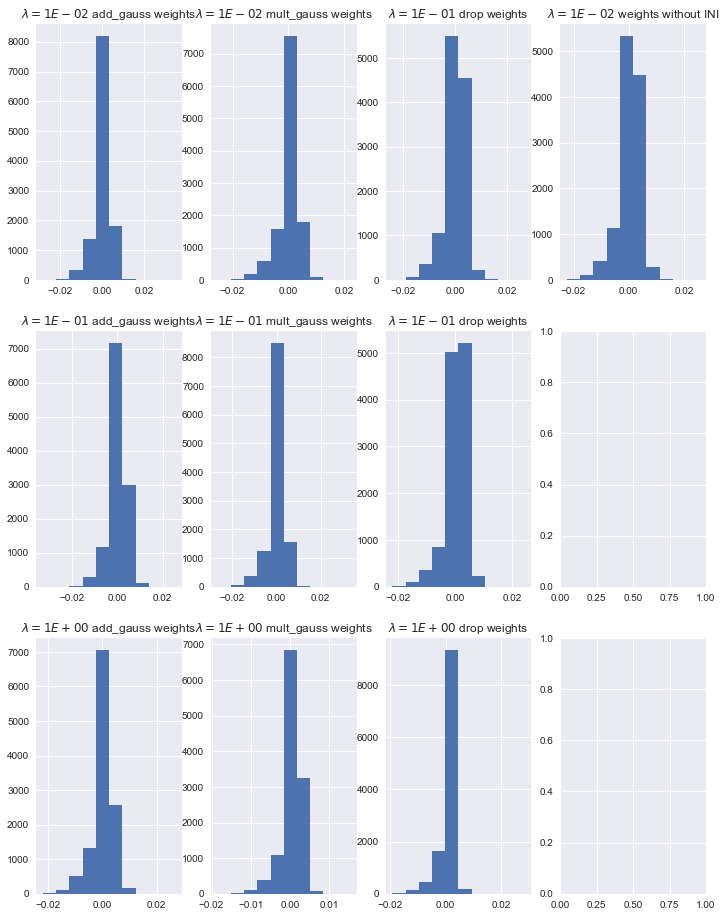

In [64]:
fig, axes = plt.subplots(figsize=(12, 16), ncols=4, nrows=3)

_ = axes[0][3].hist(act1_linear[0].flatten())
axes[0][3].set_title(r'$\lambda = %0.0E$ weights without INI' % lambdas[0])

_ = axes[0][0].hist(act1_add[0].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[0])
_ = axes[0][1].hist(act1_mult[0].flatten())
axes[0][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[0])
_ = axes[0][2].hist(act1_drop[0].flatten())
axes[0][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[1][0].hist(act1_add[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[1])
_ = axes[1][1].hist(act1_mult[1].flatten())
axes[1][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[1])
_ = axes[1][2].hist(act1_drop[1].flatten())
axes[1][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[2][0].hist(act1_add[2].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[2])
_ = axes[2][1].hist(act1_mult[2].flatten())
axes[2][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[2])
_ = axes[2][2].hist(act1_drop[2].flatten())
axes[2][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[2])
plt.show()

In [131]:
#np.std(x_train[,np.where(np.array(abs(act1_drop[2])>0.015))[0]])
np.std(x_train[:,np.where(np.array(abs(act1_drop[2])>0.015))[1]],axis=0)

#np.std(x_train[:,np.where(np.array(abs(act1_drop[2])>0.015))[0]],axis=0)

array([3045.3076, 2992.516 , 2933.0552, 2784.9563, 2872.541 , 3015.806 ,
       2740.7122, 2827.053 , 3002.088 , 2977.0737, 2952.1895],
      dtype=float32)

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


x_df=pd.DataFrame(x_train)
correlation=x_df.corr()

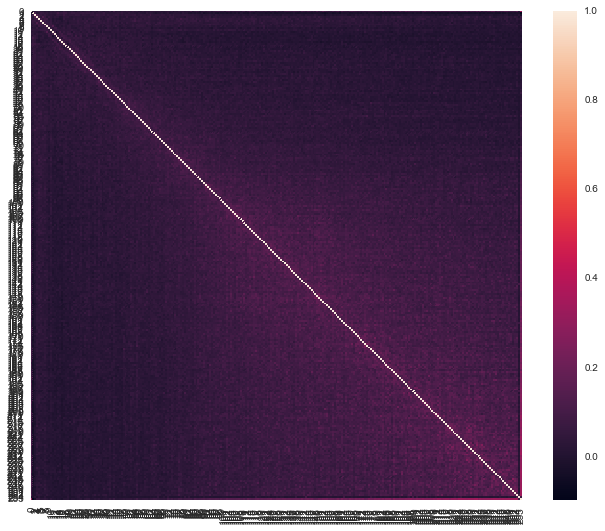

In [94]:
#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Generate a mask for the upper triangle
#mask = np.zeros_like(correlation, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(correlation, cmap=cmap, vmax=1, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.1})
# plot the heatmap
sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)